## Section 1

Question (1), I argue that $\mathbb{E}[X'u]=0$ implies that $\mathbb{E}[f(X')u]=0$ for any measurable function $f(\cdot)$. Below I show a series of Monte Carlo estimations of $f(X')u$ using functionals forms of $f(\cdot)$ in the following three categories:
1. Polynomials of the form $aX'^k+bX'^{k-1}$
2. Functions in the form $a\sin(bX'^k)$
3. Functions of the form $ae^{bX'}$

I run the simulation using 1,000 Monte Carlo draws to show that in expectation, $f(X')u$ will be equal to 0 for various measurable functional forms of $f(\cdot)$. 

In [121]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
N=100
sigma_u = 1 # Note assumption of homoskedasticity
## Play with us!

from scipy.stats import distributions as iid

D = 1000 # Monte Carlo draws
K=6
A=6
B=6

for k in range(K):
    for a in range(A):
        for b in range (B):
            globals()["mean%s_%s_%s_draws"%(k,a,b)] = []
            globals()["mean_trig_%s_%s_%s_draws"%(k,a,b)] = []
            globals()["mean_e_%s_%s_%s_draws"%(k,a,b)] = []

mean_draws = []
for d in range(D):
    u = iid.norm.rvs(size=(N,1))*sigma_u
    X = iid.norm.rvs(size=(N,1))
    mean = float(X.T@u)
    mean_draws.append(mean)
    
    for k in range(K):
        for a in range(A):
            for b in range (B):        
                globals()["mean%s_%s_%s"%(k,a,b)] = float((a*X.T**k+b*X.T**(k-1))@u)
                globals()["mean_trig_%s_%s_%s"%(k,a,b)] = float((a*np.sin(b*X.T**(k)))@u)
                globals()["mean_e_%s_%s_%s"%(k,a,b)] = float((a*np.exp(b*X.T))@u)
                globals()["mean%s_%s_%s_draws"%(k,a,b)].append(globals()["mean%s_%s_%s"%(k,a,b)])
                globals()["mean_trig_%s_%s_%s_draws"%(k,a,b)].append(globals()["mean_trig_%s_%s_%s"%(k,a,b)])
                globals()["mean_e_%s_%s_%s_draws"%(k,a,b)].append(globals()["mean_e_%s_%s_%s"%(k,a,b)])

Below I graph the Monte Carlo estimates of $X'u$, we can see that in expectation, $X'u$ is equal to 0 such that our assumption $\mathbb{E}[u|X]=\mathbb{E}[X'u]=0$ holds.

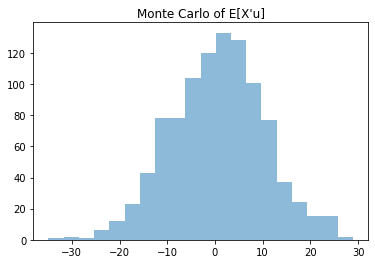

In [53]:
_ = plt.hist(mean_draws, bins = 20, alpha = 0.5)
_ = plt.title("Monte Carlo of E[X'u]")

Below I graph the Monte Carlo estimates of $f(X')u$ using a wide arraw of functional forms of $f(\cdot)$. We can again see that across the three categories, the expectation $\mathbb{E}[f(X')u]=0$ holds, although we do see that the variance of our estimates changes for the different categories of functional forms. 

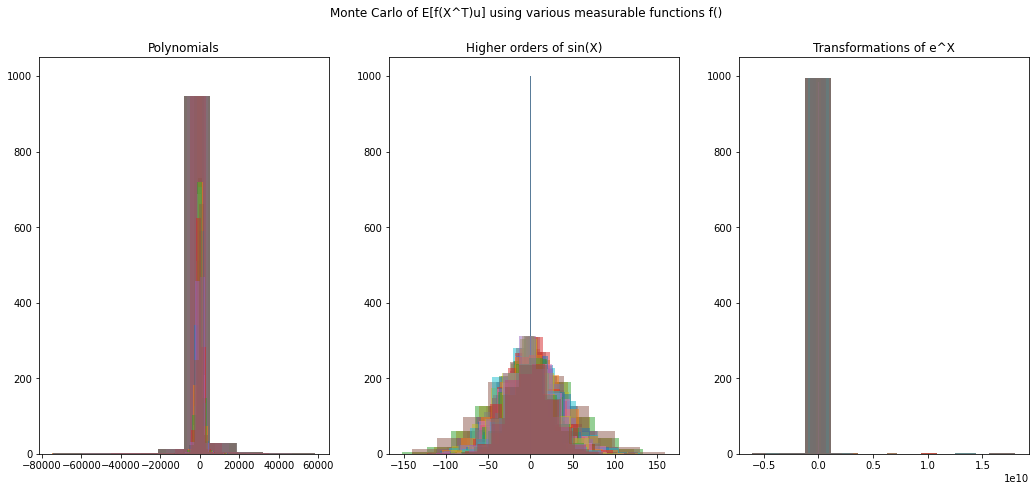

In [122]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))
fig.tight_layout(pad=3.0)

for k in range(K):
    for a in range(A):
        for b in range (B):
            ax[0].hist(globals()["mean%s_%s_%s_draws"%(k,a,b)], alpha = 0.5)
            ax[0].set_title("Polynomials")
            ax[1].hist(globals()["mean_trig_%s_%s_%s_draws"%(k,a,b)], alpha = 0.5)
            ax[1].set_title("Higher orders of sin(X)")
            ax[2].hist(globals()["mean_e_%s_%s_%s_draws"%(k,a,b)], alpha = 0.5)
            ax[2].set_title("Transformations of e^X")
            
_ = fig.suptitle('Monte Carlo of E[f(X^T)u] using various measurable functions f()') 
_ = fig.subplots_adjust(top=0.88)

## Section 3

(2) Below we run a GMM test for the null of conditional homoskedasticity:

In [123]:
import numpy as np
from numpy.linalg import inv

## Play with us!
alpha = 2
beta = 1 # "Coefficient of interest"
gamma = 0 # Governs effect of u on X
sigma_u = 1 # Note assumption of homoskedasticity
## Play with us!

# Gimme some truth:
truth = (alpha,beta,gamma,sigma_u)

## But play with Omega if you want to introduce heteroskedascity
Omega = (sigma_u**2)


from scipy.stats import distributions as iid


def dgp(N,alpha,beta,gamma,sigma_u):
    """Generate a tuple of (y,X,Z).
      
    Satisfies model:
        y = a+X@beta + u
        E X'u = 0
        Var(u) = sigma^2
        Cov(X,u) = gamma*sigma_u^2
        u,X mean zero, Gaussian

    Each element of the tuple is an array of N observations.

    Inputs include
    - beta :: the coefficient of interest
    - gamma :: linear effect of disturbance on X
    - sigma_u :: Variance of disturbance
    """
    
    u = iid.norm.rvs(size=(N,1))*sigma_u
    
    # Generate normal random variates [X*,Z]
    XZ = iid.norm.rvs(size=(N,1))
    
    # But X is endogenous...
    X = XZ[:,[0]] + gamma*u
    
    # Calculate y
    y = alpha + X*beta + u
    
    return y,X

def gj(b,s,data):
    """Observations of g_j(b).
    
    This defines the deviations from the predictions of our model; i.e.,
    e_j = Z_ju_j, where EZ_ju_j=0.
    
    Can replace this function to testimate a different model.
    """
    y,X = data
    return np.hstack((X*(y - X*b), X*((y - X*b)**2)-X*(s**2)))

def gN(b,s,data):
    """Averages of g_j(b).
    
    This is generic for data, to be passed to gj.
    """
    e = gj(b,s,data)
    
    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1]
    
    return e.mean(axis=0)

def Omegahat(b,s,data):
    y,X = data
    
# If we have that the optimal weighting matrix W=E[Z'Z]^{-1}\sigma^2 and Omegahat = W^{-1}
    e = gj(b,s,data)[:,:1]
    e = e - e.mean(axis=0)
    
    return np.vstack((np.hstack((e.T@e/(e.shape[0]), np.zeros((X.shape[1],X.shape[1])))),
                      np.hstack((np.zeros((X.shape[1],X.shape[1])), (e**2-s**2).T@(e**2-s**2)))))

N = 1000
data = dgp(N,*truth)
y,X = data
Winv = Omegahat(beta,sigma_u,data)

def J(b,s,W,data):
    
    m = gN(b,s,data) # Sample moments @ b, s
    N = data[0].shape[0]
    
    return N*m.T@W@m # Scale by sample size

# Limiting distribution under the null
limiting_J = iid.chi2(1*2-2)

import scipy.optimize as optimize

def two_step_gmm(data):
    
    # First step uses identity weighting matrix
    W1 = np.eye(gj(1,1,data).shape[1])
    x0 = [1,1]
    def J2(params):
        b,s = params
        return J(b,s,W1,data)
    
    result = optimize.minimize(J2, x0)
    b1, s1 = result.x
    
    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = inv(Omegahat(b1,s1,data))
    
    def J3(params):
        b,s = params
        return J(b,s,W2,data)
    
    return optimize.minimize(J3, result.x)

soltn = two_step_gmm(data)
print("b=%f, s=%f, J=%f, Critical J=%f" % (soltn.x[0],soltn.x[1],soltn.fun,limiting_J.isf(0.05)))


b=0.986899, s=15.922028, J=0.000000, Critical J=nan


## Section 5

We test under conditions $b_W$ using the weighting matrix described in (6) will be equal to the optimally weighted estimator. This dgp is borrowed from Ethan's function with the small modification to allow for heteroskedasiticty.

In [110]:
import numpy as np
from numpy.linalg import inv
from matplotlib import pyplot as plt
from scipy.stats import distributions as iid

def dgp(N,beta,gamma,sigma_u,VXZ,het):
    
    # "Square root" of VXZ via eigendecomposition
    lbda,v = np.linalg.eig(VXZ)
    SXZ = v@np.diag(np.sqrt(lbda))
    
    # Generate normal random variates [X*,Z]
    XZ = iid.norm.rvs(size=(N,VXZ.shape[0]))@SXZ.T
    Z = XZ[:,1:]
    
    #Allow for heteroskedasticity (Ex[u^2|Z]\neq \s^2)
    if het == "het":
        sigma_u = (abs(Z)**0.5)[:,[0]]
    else: 
        sigma_u = sigma_u
    
    u = iid.norm.rvs(size=(N,1))*sigma_u
    
    # But X is endogenous...
    X = XZ[:,[0]] + gamma*u
    
    # Calculate y
    y = X*beta + u
    
    return y,X,Z


def bW(W, data):
    y,X,Z = data
    return float(np.linalg.pinv(W@Z.T@X)@W@Z.T@y)

def biv(data):
    y,X,Z = data    
    return float(inv(X.T@Z@inv(Z.T@Z)@Z.T@X)@(X.T@Z@inv(Z.T@Z)@Z.T@y))

def gj(b,y,X,Z):
    """Observations of g_j(b).

    This defines the deviations from the predictions of our model; i.e.,
    e_j = Z_ju_j, where EZ_ju_j=0.

    Can replace this function to testimate a different model.
    """
    return Z*(y - X*b)

def gN(b,data):
    """Averages of g_j(b).

    This is generic for data, to be passed to gj.
    """
    e = gj(b,*data)

    # Check to see more obs. than moments.
    assert e.shape[0] > e.shape[1]
    
    return e.mean(axis=0)

def Omegahat(b,data):
    e = gj(b,*data)

    # Recenter! We have Eu=0 under null.
    # Important to use this information.
    e = e - e.mean(axis=0) 
    
    return e.T@e/e.shape[0]

def J(b,W,data):

    m = gN(b,data) # Sample moments @ b
    N = data[0].shape[0]

    return N*m.T@W@m # Scale by sample size

from scipy.optimize import minimize_scalar

def two_step_gmm(data):

    # First step uses identity weighting matrix
    W1 = np.eye(gj(1,*data).shape[1])

    b1 = minimize_scalar(lambda b: J(b,W1,data)).x 

    # Construct 2nd step weighting matrix using
    # first step estimate of beta
    W2 = inv(Omegahat(b1,data))

    return minimize_scalar(lambda b: J(b,W2,data))


We can now test our various estimates using a Monte Carlo simulation. Here we allow for a sample size of 1000 and test models that are just-identified, over-identified, and have heteroskedastic and homoskedastic errors. 


I would like to thank Lucy Hackett for the code that shows to make nice looking subplots in the HFUL piazza discussion.

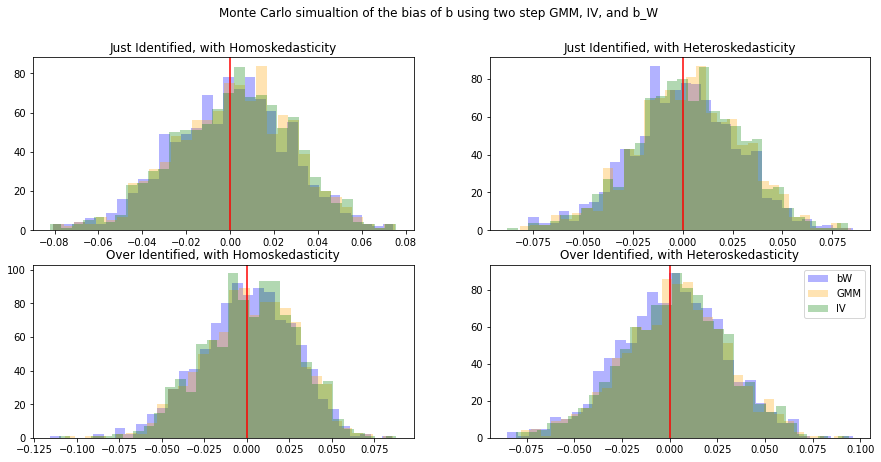

In [120]:
beta = 1
gamma = 1 # Governs effect of u on X
sigma_u = 1

N = 1000
D = 1000 # Monte Carlo draws

ell_options = [1, 4]

fig, ax = plt.subplots(2, 2, figsize=(15, 7))
colcount = 0
rowcount = 0
het = ''

for g in ("Homoskedasticity","Heteroskedasticity"):
    ## But play with Omega if you want to introduce heteroskedascity
    
    if g == "Homoskedasticity":
        het == "het"
    else: 
        het == "nohet"
    
    for iden in ("Just Identified", "Over Identified"):

        if g == "Just Identified":
            ell = 1
        else: 
            ell = 4

        A = np.sqrt(1/np.arange(1,(ell+1)**2+1)).reshape((ell+1,ell+1))

        # Now Var([X,Z]|u) is constructed so guaranteed pos. def.
        VXZ = A.T@A
        
        Q = -VXZ[1:,[0]] # -EZX', or generally Edgj/db'
    
        truth = (beta,gamma,sigma_u,VXZ,het)
    
        
        diag = []
        for q in range(ell):
            d = 2**(1-q)
            diag.append(d)

        W = np.diag(diag)

        bW_draws = []
        bGMM_draws = []
        bIV_draws = []
        for d in range(D):
            data = dgp(N,*truth)
            b = bW(W, data) - beta
            bW_draws.append(b)
            b_iv = biv(data) - beta
            bIV_draws.append(b_iv)
            bGMM = two_step_gmm(data).x - beta
            bGMM_draws.append(bGMM)

        ax[rowcount, colcount].hist(bW_draws,bins=int(np.ceil(np.sqrt(1000))), color='blue', alpha=0.3, label="bW")
        ax[rowcount, colcount].hist(bIV_draws,bins=int(np.ceil(np.sqrt(1000))), color='orange', alpha=0.3, label="GMM")
        ax[rowcount, colcount].hist(bGMM_draws,bins=int(np.ceil(np.sqrt(1000))), color='green', alpha=0.3, label="IV")
        ax[rowcount, colcount].set_title(iden+", with "+g)
        ax[rowcount, colcount].axvline(0, color='r')

        rowcount += 1
    
    rowcount = 0 
    colcount += 1

plt.legend()
_ = fig.suptitle('Monte Carlo simualtion of the bias of b using two step GMM, IV, and b_W') 

The graphs above show that the bias of our estimate b does not vary greatly across the three different estimators, in any of the four cases shown. 